In [44]:
from minisom import MiniSom    
from sklearn.cluster import KMeans
import numpy as np
#data = np.genfromtxt('iris.csv', delimiter=',', usecols=(0, 1, 2, 3))

data_point_size = 10
data = np.genfromtxt('10clusters.vec', skip_header=4, usecols=list(range(data_point_size)))
#data = np.genfromtxt('chainlink.vec', skip_header=4, usecols=list(range(3)))
# data normalization

data = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, data)

# Initialization and training
d1 = 15
d2 = 15
som = MiniSom(d1, d2, data_point_size, sigma=.3, learning_rate=0.5, neighborhood_function='gaussian', random_seed=2)

#som = MiniSom(d1, d2, data_point_size, sigma=3, learning_rate=0.5, 
#              neighborhood_function='triangle', random_seed=10)
#som.train_random(data,1000)

print("Training...")
print(som.quantization_error(data))
print(som.topographic_error(data))
som.pca_weights_init(data)
som.train_batch(data, 1000, verbose=True)  # random training

#som.neighborhood(som.winner(data[0]),2)

#som = MiniSom(3, 3, 4, sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
#som.train_random(data, 100) # trains the SOM with 100 iterations


Training...
0.05704776936649882
1.0
 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.011028026094612016
 topographic error: 0.23058823529411765


In [3]:
def winners_labels(som,rweights,labels):
    winners_labels = np.zeros(shape=(d1,d2))
    for cnt, xx in enumerate (rweights):
        w = som.winner(xx)
        l = labels[cnt]
        winners_labels[w[0],w[1]] = l
    return winners_labels

def dif_matrix(label_matrix):
    dif_mat = np.zeros(shape=label_matrix.shape)
    for i,row in enumerate(label_matrix):
        for j,label in enumerate(row):
            if i < label_matrix.shape[0]-1 and label_matrix[i][j] != label_matrix[i+1][j]:
                dif_mat[i][j] = 1
            elif j < label_matrix.shape[1]-1 and label_matrix[i][j] != label_matrix[i][j+1]:
                dif_mat[i][j] = 1
    return dif_mat


In [4]:

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
%load_ext autoreload

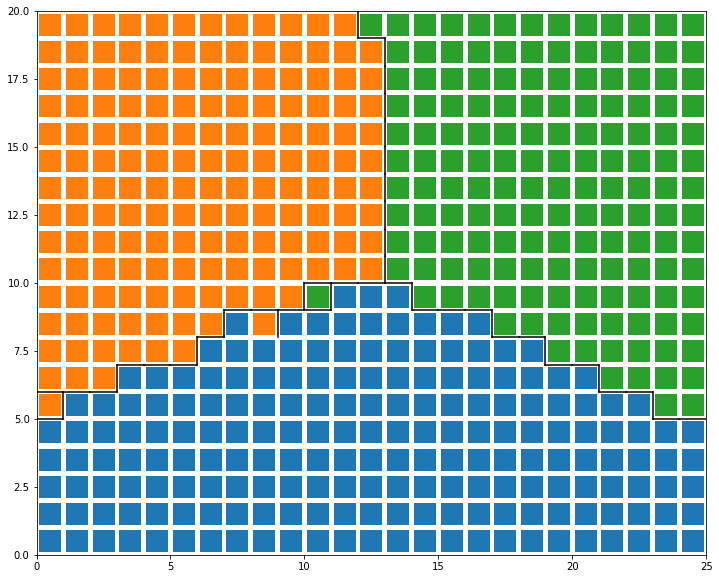

In [32]:

def plot_with_labelling(som, d1, d2, n_clusters, labels, rweights, debug=False):

    plt.figure(figsize=(d1//2, d2//2))
    # Plotting the response for each pattern in the iris dataset
    #win_map = som.win_map(rweights)
    #plt.pcolor(som.distance_map().T, cmap='bone_r')  # plotting the distance map as background
    #plt.colorbar()
    # use different colors and markers for each label
    #markers = ['o', 's', 'D']
    colors = ['C' + str(i) for i in np.unique(labels)] #['C0', 'C1', 'C2', 'C3', 'C4']
    win_labels = winners_labels(som,rweights,labels)
    diff_mat_ = dif_matrix(win_labels)
    diff_mat = np.append(diff_mat_,np.ones((diff_mat_.shape[0],1)),axis=1)
    diff_mat = np.append(diff_mat,np.ones((1,diff_mat.shape[1])),axis=0)

    for cnt, xx in enumerate(rweights):
        w = som.winner(xx)  # getting the winner
        #w = xx
        # palce a marker on the winning position for the sample xx
        plt.plot(w[0]+.5, w[1]+.5, 's', markerfacecolor=colors[labels[cnt]],
                markeredgecolor=colors[labels[cnt]], markersize=20, markeredgewidth=2)
    def plot_borders(debug=False):
        border_color = lambda c : c if debug else 'black'
        for i,row in enumerate(diff_mat):
            for j,v in enumerate(row):
                if i < diff_mat.shape[0]-1 and j < diff_mat.shape[1]-1:
                    if v != 0: 
                        # case where
                        # - -  -
                        # -[1] 1
                        # - -  -
                        # then draw horizontal line
                        if i > 0 and diff_mat[i-1][j] != 0:
                            plt.plot([i,i+1],[j+1,j+1], color=border_color('red'))
                        # edge case where
                        # - - -
                        # [1] -
                        # - - -
                        # then draw horizontal line
                        elif i == 0 and j != 0:
                            plt.plot([i,i+1],[j+1,j+1], color=border_color('green'))    
                        # case where
                        # - 0  1
                        # -[1] 0
                        # - -  -
                        # then draw horizontal line
                        elif i > 0 and diff_mat[i-1][j] == 0 and diff_mat[i][j+1] == 0 and diff_mat[i-1][j+1] != 0:
                            plt.plot([i,i+1],[j+1,j+1], color=border_color('blue'))
                        # case where
                        # - 1  -
                        # -[1] -
                        # - -  -
                        # then draw vertical line
                        if diff_mat[i][j+1] != 0:
                            plt.plot([i+1,i+1],[j+1,j+2], color=border_color('black'))
                        # edge case where
                        # - [1] -
                        # -  -  -
                        # then draw vertical line
                        if j == 0 and i != 0:
                            plt.plot([i+1,i+1],[j,j+1], color=border_color('brown'))    
                    # case where
                    # - -  -
                    # -[0] 1
                    # - 1  0
                    # then draw vertical line
                    elif diff_mat[i+1][j] != 0 and diff_mat[i][j+1] != 0 and diff_mat[i+1][j+1] == 0:
                        plt.plot([i+1,i+1],[j+1,j+2], color=border_color('purple'))
    plot_borders(debug)
    plt.axis([0, d1, 0, d2])
    plt.show()

n_clusters = 3
rweights = som.get_weights().reshape(d1*d2,-1) # first argument is product of first two dimensions of the input dataset
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(rweights)
labels = kmeans.labels_
plot_with_labelling(som,d1,d2,n_clusters,labels,rweights,debug=False)


In [0]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
label = kmeans.labels_    
labels_map = som.labels_map(data, label)
label_names = np.unique(label)
plt.figure(figsize=(d1, d2))
the_grid = GridSpec(d1, d2)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[position[0], position[1]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.show()

In [0]:
plt.figure(figsize=(d1, d2))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2
 3 0 0 0 0 0 0 0 0 0 0 0 4 1 3 3 3 0 0 0 0 0 0 0 0 0 0 0 1 1 3 0 0 0 0 0 0
 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


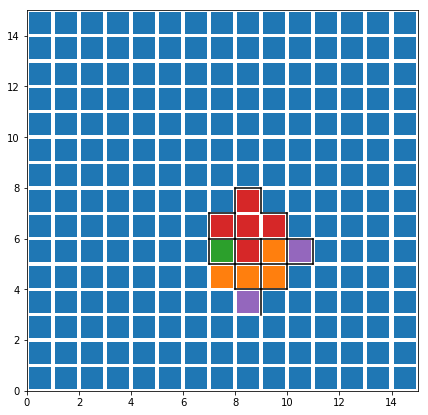

In [48]:
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster,cut_tree
from matplotlib import pyplot as plt
#X = np.genfromtxt('iris.csv', delimiter=',', usecols=(0, 1, 2, 3))



rweights = som.get_weights().reshape(d1*d2,-1)
Z = linkage(rweights, 'single')

n_clusters = 5
cuttree= cut_tree(Z,n_clusters=[3,n_clusters])
#print(cuttree)
C = fcluster(Z, t=10, criterion='maxclust')
#print(C)

labels = cuttree.T[1]
print(labels)
plot_with_labelling(som,d1,d2,n_clusters,labels,rweights,debug=False)

